# 11장. 그룹 연산
그룹 연산: [분리-적용-결합](http://www.stat.wvu.edu/~jharner/courses/stat623/docs/plyrJSS.pdf)
---

1. 분리: Series. DataFrame과 같은 pandas 객체나 다른 객체에 들어 있는 데이터를 하나 이상의 색인(또는 컬럼)을 기준으로 분리.
    - 분리 기준: row(axis=0)나 column(axis=1)
    - 여기서 색인은 pandas 객체의 index라기 보다는 그룹을 분리할 수 있는 어떤 범주형 배열임.
2. 적용: 함수를 각 그룹에 적용시켜 새로운 값을 얻어냄.
3. 결합: 함수를 적용한 결과를 하나의 객체로 결합.
    - 결과를 담는 객체는 보통 데이터에 어떤 '연산'을 했는지에 따라 결정.
    - 결합된 결과(그룹 연산의 결과)의 index는 groupby의 by 옵션에 지정된 group key이다.

그룹 연산의 예:
---

![](https://i.stack.imgur.com/sgCn1.jpg)

[그룹 연산의 종류](https://pandas.pydata.org/pandas-docs/stable/groupby.html):
---
1. 벡터 => 스칼라: `aggregation(func[, **args])` ( 평균, 합, 최대값 )
    - group 별 통계량 등. list로 여러 개를 지정할 수 있다.
    ```python
    grouped.agg([np.sum, np.mean, np.std])
    ```
    - column 별로 다른 통계량을 제공할 수 있다.
    ```python
    grouped.agg({'C' : np.sum, 'D' : lambda x: np.std(x, ddof=1)})
    ```
2. 벡터 => (동일한 사이즈의) 벡터: `transform(func[, **args])`
    - group-specific 연산으로 동일한 size의 index를 갖는 결과를 리턴.
    - 각 group chunk는 immutable로 간주되어 inplace 연산은 불가능하다.
    - group 별 유도된 값(gorup 별 평균 등)으로 Na 대체
    - gorup 별 표준화 등 여러 개의 함수를 지정할 수도 있다.
```python
s = pd.Series(range(3))
s.transform([np.sqrt, np.exp])
```
3. 벡터 => (임의의) 벡터: `apply(func[, **args])`
    - 많은 경우, agg, transform, filter에 의해 대체될 수 있지만,
    - apply 만의 예외적인 사용성을 갖는다.
    ```python
    arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
              ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]
    index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second'])
    df = pd.DataFrame({'A': [1, 1, 1, 1, 2, 2, 3, 3],
                       'B': np.arange(8)}, index=index)
    grouped = df.groupby('A')['B']
    def f(group):
        return pd.DataFrame({'original' : group, 'demeaned' : group - group.mean()})
    grouped.apply(f)
    ```
4. all groups => some groups: `filter(func[, **args])`
    - func의 인수는 각 group이고, func는 보통 boolean을 리턴한다.
    - 각 group에 대한 func 결과에 따라, false로 리턴된 group은 제거된다.
    ```python
    dff = pd.DataFrame({'A': np.arange(8), 'B': list('aabbbbcc')})
    dff.groupby('B').filter(lambda x: len(x) > 2)
    ```


그룹 키의 형태:
---

1. 그룹으로 묶을 축의 길이와 동일한 길이의 리스트나 배열
2. DataFrame의 칼럼 이름을 지칭하는 값
3. 그룹으로 묶을 값과 그룹 이름에 대응하는 사전이나 Series 객체
4. 축 색인 또는 색인 내의 개별 이름에 대해 실행되는 함수

참고:
---
1. agg, apply, transform, filter 함수는 DataFrame 또는 GroupByDataFrame 모두에 적용할 수 있으나,
2. map, applymap 등은 GoupBy 객체에 사용할 수 없다.

추가로:
---
아래와 같이 groupby 객체에 대해:
1. agg: 함수의 list와 변수별 병합함수를 dict로 전달할 수 있다.
2. transform: 함수의 list만 전달할 수 있다.
3. apply: 함수의 list도 dict도 모두 전달할 수 없다.

반면, DataFrame이나 Series 객체에 대해서는:
1. agg: 함수의 list와 변수별 병합함수를 dict로 전달할 수 있다.
2. transform: 함수의 list와 변수별 병합함수를 dict로 전달할 수 있다.
3. map, applymap: map 류의 함수에서는 어떤 것도 불가능하다.
4. apply: 함수의 list와 변수별 병합함수를 dict로 전달할 수 있다.


## 11.1 데이터 집계
### 11.1.1 groupby 메서드로 평균값 구하기(215쪽)
groupby로 평균을 구하는 과정에서 데이터 집계가 무엇인지 알아보자.

In [1]:
import pandas as pd
df = pd.read_csv('../data/gapminder.tsv', sep='\t')

In [2]:
df.year.unique()

array([1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002,
       2007], dtype=int64)

아래 코드는 모두 동일하다.
- df.groupby('year').lifeExp.mean()
- df.lifeExp.groupby(df.year).mean()
- df.groupby('year').mean()['lifeExp']

In [7]:
df.groupby('year').lifeExp.mean()     # 속도 2등 - 모든 걸 쪼개
df.lifeExp.groupby(df.year).mean()    # 속도 1등
df.groupby('year').mean()['lifeExp']  # 속도 꼴등 - 모두 쪼게로 적용하여 합친다.
df.groupby('year').mean().lifeExp     # 위와 동문

year
1952    49.057620
1957    51.507401
1962    53.609249
1967    55.678290
1972    57.647386
1977    59.570157
1982    61.533197
1987    63.212613
1992    64.160338
1997    65.014676
2002    65.694923
2007    67.007423
Name: lifeExp, dtype: float64

In [2]:
avg_life_exp_by_year = df.groupby('year').lifeExp.mean() 
print(avg_life_exp_by_year)

# avg_life_exp_by_year = df.groupby('year')['lifeExp'].mean()
# print(avg_life_exp_by_year)

year
1952    49.057620
1957    51.507401
1962    53.609249
1967    55.678290
1972    57.647386
1977    59.570157
1982    61.533197
1987    63.212613
1992    64.160338
1997    65.014676
2002    65.694923
2007    67.007423
Name: lifeExp, dtype: float64


### 11.1.2 분할-적용-결합 과정 살펴보기(216쪽)

#### 1) 연도별로 데이터를 분할

In [8]:
years = df.year.unique() 
print(years)

[1952 1957 1962 1967 1972 1977 1982 1987 1992 1997 2002 2007]


In [9]:
# y1952 = df.loc[df.year == 1952, :] 
y1952 = df[df.year == 1952] 
print(y1952.head())

        country continent  year  lifeExp       pop    gdpPercap
0   Afghanistan      Asia  1952   28.801   8425333   779.445314
12      Albania    Europe  1952   55.230   1282697  1601.056136
24      Algeria    Africa  1952   43.077   9279525  2449.008185
36       Angola    Africa  1952   30.015   4232095  3520.610273
48    Argentina  Americas  1952   62.485  17876956  5911.315053


#### 2) 연도별 평균함수를 적용

In [10]:
y1952_mean = y1952.lifeExp.mean() 
print(y1952_mean)

49.05761971830987


다른 연동에서도 차곡차곡 분할과 집계를 수행합니다.

In [11]:
y1957 = df.loc[df.year == 1957, :] 
y1957_mean = y1957.lifeExp.mean( )
print(y1957_mean)

y1962 = df.loc[df.year == 1962, :] 
y1962_mean = y1962.lifeExp.mean( )
print(y1962_mean)

y2007 = df.loc[df.year == 2007, :] 
y2007_mean = y2007.lifeExp.mean( )
print(y2007_mean)

51.50740112676054
53.60924901408449
67.00742253521126


#### 3) 집계 결과를 결합

In [13]:
df2 = pd.DataFrame({"year":[1952, 1957, 1962, 2007], 
                    "meanLifeExp":[y1952_mean, y1957_mean,y1962_mean,y2007_mean]}) 
print(df2)

   year  meanLifeExp
0  1952    49.057620
1  1957    51.507401
2  1962    53.609249
3  2007    67.007423


#### 한번에 표현하면

In [14]:
aggdict = {}
for year, group in df.groupby('year'):
    aggdict[year] = group.lifeExp.mean()
    
pd.Series(aggdict)

1952    49.057620
1957    51.507401
1962    53.609249
1967    55.678290
1972    57.647386
1977    59.570157
1982    61.533197
1987    63.212613
1992    64.160338
1997    65.014676
2002    65.694923
2007    67.007423
dtype: float64

In [16]:
pd.Series(aggdict).reset_index()

,index,0
0,1952,49.057620
1,1957,51.507401
2,1962,53.609249
3,1967,55.678290
4,1972,57.647386
5,1977,59.570157
6,1982,61.533197
7,1987,63.212613
8,1992,64.160338
9,1997,65.014676


In [17]:
pd.Series(aggdict).to_frame()

,0
1952,49.057620
1957,51.507401
1962,53.609249
1967,55.678290
1972,57.647386
1977,59.570157
1982,61.533197
1987,63.212613
1992,64.160338
1997,65.014676


## 11.2 집계 메소드
아래는 일반적인 집계함수로서, 당연히 GrouBy 객체에 사용할 수 있다.
![](https://i.imgur.com/uFZxsp7.png)

GroupBy 객체에는 아래 표와 같이 통계계산을 위한 많은 메소드를 제공하고 있다. 
<table>
  <tr>
    <th>GroupBy 메소드</th>
    <th>설명</th>
  </tr>
  <tr>
    <td>count()</td>
    <td>결측치를 제외한 group 빈도 계산</td>
  </tr>
  <tr>
    <td>first(), last()</td>
    <td>NA가 아닌 값 중 첫번째와 마지막 값</td>
  </tr>
  <tr>
    <td>head([n]), tail([n])</td>
    <td>각 group별 첫 또는 마지막 n rows를 리턴</td>
  </tr>
  <tr>
    <td>max(), min()</td>
    <td>group 최대값, 또는 최소값</td>
  </tr>
  <tr>
    <td>mean(), median()</td>
    <td>결측치를 제외한 group 평균, 또는 중간값</td>
  </tr>
  <tr>
    <td>ngroup([ascending])</td>
    <td>각 group별로 0 ~ (그룹 size - 1)까지 넘버링</td>
  </tr>
  <tr>
    <td>nth(n[, dropna])</td>
    <td>n이 정수면, n번째 row를, n이 list of int인 경우, n개 rows의 subset를 리턴</td>
  </tr>
  <tr>
    <td>ohlc()</td>
    <td>결측치를 제외한 open, high, low, close를 계산</td>
  </tr>
  <tr>
    <td>prod()</td>
    <td>group 값들의 곱을 계산</td>
  </tr>
  <tr>
    <td>size()</td>
    <td>group의 행의 수를 계산</td>
  </tr>
  <tr>
    <td>sem([ddof])</td>
    <td>결측치를 제외한 group 평균의 표준오차를 계산</td>
  </tr>
  <tr>
    <td>std([ddof])</td>
    <td>결측치를 제외한 group의 표준편차를 계산</td>
  </tr>
  <tr>
    <td>sum()</td>
    <td>group 값의 합을 계산</td>
  </tr>
  <tr>
    <td>var([ddof])</td>
    <td>결측치를 제외한 group의 분산을 계산</td>
  </tr>
  <tr>
    <td>quantile(**kwargs)</td>
    <td>각 qroup별 백분율을 계산<br></td>
  </tr>
</table>

### 11.2.1 agg 메소드로 집계하기
agg 메소드의 인자로 함수를 사용하는데, 이 함수는 vector 즉, 1d Array에 대해 reduce 연산을 수행하는 함수여야 한다.
#### 1) 평균값을 구하는 사용자 함수와 groupby 메서드(219쪽)
메소드에서 제공하지 않는 함수들은 집적 작성하여 적용해야 한다. 예로서, 사용자 정의 평균함수를 적용하는 예를 살펴보자.

In [18]:
def my_mean(values):
    n = len(values)
    
    sum = 0 
    for value in values:
        sum += value
    
    return sum / n

In [9]:
# agg_my_mean = df.groupby('year').lifeExp.mean()
agg_my_mean = df.groupby('year').lifeExp.agg(my_mean) 
print(agg_my_mean)

year
1952    49.057620
1957    51.507401
1962    53.609249
1967    55.678290
1972    57.647386
1977    59.570157
1982    61.533197
1987    63.212613
1992    64.160338
1997    65.014676
2002    65.694923
2007    67.007423
Name: lifeExp, dtype: float64


<font color='red'>[Quiz] </font> 평균편차를 제공하는 함수를 작성하여, 년도별로 lifeExp에 대해 집계하세요.
$$\text{Mean Deviation} (X) = \cfrac {\sum_{i=1}^N |X_j - \bar X|}{N}$$
- $Z = |X - \bar X|$
- $\text{Mean Deviation} (X) = \bar Z$

In [29]:
import numpy as np
meanDev = lambda vec: np.abs(vec - vec.mean()).mean()

In [43]:
df.groupby('year').lifeExp.agg(meanDev)

year
1952    10.717504
1957    10.823396
1962    10.768747
1967    10.382982
1972    10.006127
1977     9.691594
1982     9.283048
1987     9.022130
1992     9.423962
1997    10.022092
2002    10.740177
2007    10.454452
Name: lifeExp, dtype: float64

In [44]:
le1952 = df[df.year == 1952].lifeExp
le1952

0       28.801
12      55.230
24      43.077
36      30.015
48      62.485
         ...  
1644    40.412
1656    43.160
1668    32.548
1680    42.038
1692    48.451
Name: lifeExp, Length: 142, dtype: float64

In [45]:
tmp = np.abs(le1952 - le1952.mean())
tmp

0       20.25662
12       6.17238
24       5.98062
36      19.04262
48      13.42738
          ...   
1644     8.64562
1656     5.89762
1668    16.50962
1680     7.01962
1692     0.60662
Name: lifeExp, Length: 142, dtype: float64

In [46]:
tmp.mean()

10.717504463400127

#### 2) 두 개의 인자값을 받아 처리하는 함수와 groupby 메서드(220쪽)
values들의 평균을 구하고, 이를 diff_value를 뺀 값을 반환하는 함수를 적용해보자.

In [19]:
def my_mean_diff(values, diff_value):
    n = len(values) 
    sum = 0 
    for value in values:
        sum += value 
    mean = sum / n 
    return mean - diff_value

In [41]:
my_mean_diff = lambda vec, diff_value: vec.mean() - diff_value

이 함수는 아래와 같이 그룹별 평균이 전체 평균과 얼마나 차이가 나는지 살펴보는데 유용하다.

In [35]:
global_mean = df.lifeExp.mean() 
print(global_mean)

59.47443936619713


In [47]:
agg_mean_diff = df.groupby('year').lifeExp.\
    agg(my_mean_diff, diff_value = global_mean) 
print(agg_mean_diff)

year
1952   -10.416820
1957    -7.967038
1962    -5.865190
1967    -3.796150
1972    -1.827053
1977     0.095718
1982     2.058758
1987     3.738173
1992     4.685899
1997     5.540237
2002     6.220483
2007     7.532983
Name: lifeExp, dtype: float64


### 11.2.2 다중 집계하기
#### 1) 집계 메서드를 리스트, 딕셔너리에 담아 전달하기(221쪽)

In [48]:
import numpy as np
gdf = df.groupby('year').lifeExp.agg(
    [np.count_nonzero, np.mean, np.std]
) 
print(gdf)

      count_nonzero       mean        std
year                                     
1952          142.0  49.057620  12.225956
1957          142.0  51.507401  12.231286
1962          142.0  53.609249  12.097245
1967          142.0  55.678290  11.718858
1972          142.0  57.647386  11.381953
1977          142.0  59.570157  11.227229
1982          142.0  61.533197  10.770618
1987          142.0  63.212613  10.556285
1992          142.0  64.160338  11.227380
1997          142.0  65.014676  11.559439
2002          142.0  65.694923  12.279823
2007          142.0  67.007423  12.073021


In [49]:
gdf.columns = ['cntExpLife','meanExpLife','stdExpLIfe']
gdf

,cntExpLife,meanExpLife,stdExpLIfe
year,,,
1952,142.0,49.057620,12.225956
1957,142.0,51.507401,12.231286
1962,142.0,53.609249,12.097245
1967,142.0,55.678290,11.718858
1972,142.0,57.647386,11.381953
1977,142.0,59.570157,11.227229
1982,142.0,61.533197,10.770618
1987,142.0,63.212613,10.556285
1992,142.0,64.160338,11.227380


각 집계함수로 생성될 열에 이름을 부여하고자 하는 경우, 
- 리스트안에 각 함수를 튜플 형식으로 (name, funt) 전달한다.
- 즉, [(name1, f1), (name2, f2), ...]

In [21]:
mulAggFts = [('cntExpLife', np.count_nonzero), 
             ('meanExpLife', np.mean), 
             ('stdExpLIfe', np.std)]
gdf = df.groupby('year').lifeExp.agg(mulAggFts) 
print(gdf)

      cntExpLife  meanExpLife  stdExpLIfe
year                                     
1952       142.0    49.057620   12.225956
1957       142.0    51.507401   12.231286
1962       142.0    53.609249   12.097245
1967       142.0    55.678290   11.718858
1972       142.0    57.647386   11.381953
1977       142.0    59.570157   11.227229
1982       142.0    61.533197   10.770618
1987       142.0    63.212613   10.556285
1992       142.0    64.160338   11.227380
1997       142.0    65.014676   11.559439
2002       142.0    65.694923   12.279823
2007       142.0    67.007423   12.073021


변수마다 서로다른 집계함수를 사용할 때는 아래와 같이 사전을 이용한다.

In [50]:
gdf_dict = df.groupby('year').agg({'lifeExp': np.mean, 'pop': 'median', 
                                   'gdpPercap': 'median'}) 
print(gdf_dict)

        lifeExp         pop    gdpPercap
year                                    
1952  49.057620   3943953.0  1968.528344
1957  51.507401   4282942.0  2173.220291
1962  53.609249   4686039.5  2335.439533
1967  55.678290   5170175.5  2678.334741
1972  57.647386   5877996.5  3339.129407
1977  59.570157   6404036.5  3798.609244
1982  61.533197   7007320.0  4216.228428
1987  63.212613   7774861.5  4280.300366
1992  64.160338   8688686.5  4386.085502
1997  65.014676   9735063.5  4781.825478
2002  65.694923  10372918.5  5319.804524
2007  67.007423  10517531.0  6124.371109


<font color='red'>[Quiz] </font> lifeExp 변수에는 평균과 표준편차를, pop에는 중간값과 IQR을, gdpPercap은 평균과 중간값을 계산하기 위해서는 어떻게 해야할까?

In [55]:
from scipy.stats import iqr
gdf_dict = df.groupby('year').agg({'lifeExp': ['mean', 'std'], 
                                   'pop': ['median', iqr], 
                                   'gdpPercap': ['mean', 'median']}) 
gdf_dict

lifeExp                    pop                  gdpPercap             
           mean        std      median          iqr          mean       median
year                                                                          
1952  49.057620  12.225956   3943953.0   7716171.50   3725.276046  1968.528344
1957  51.507401  12.231286   4282942.0   8248786.75   4299.408345  2173.220291
1962  53.609249  12.097245   4686039.5   9195722.50   4725.812342  2335.439533
1967  55.678290  11.718858   5170175.5  10579816.25   5483.653047  2678.334741
1972  57.647386  11.381953   5877996.5  12328008.00   6770.082815  3339.129407
1977  59.570157  11.227229   6404036.5  13910509.75   7313.166421  3798.609244
1982  61.533197  10.770618   7007320.0  15401038.50   7518.901673  4216.228428
1987  63.212613  10.556285   7774861.5  17752553.00   7900.920218  4280.300366
1992  64.160338  11.227380   8688686.5  19099390.50   8158.608521  4386.085502
1997  65.014676  11.559439   9735063.5  20541220.00   9090.175363  4781.825478
2002  65.694923  12.279823  10372918.5  22372050.25   9917.848365  5319.804524
2007  67.007423  12.073021  10517531.0  26702008.25  11680.071820  6124.371109

사용자정의 함수를 생성하여, 사용하면:

In [46]:
def IQR(vec):
    tmp = np.quantile(vec, [.25, .75])
    return tmp[1] - tmp[0]

def IQR(vec, q1=.25, q3=.75):
    dev = vec.quantile(q3) - vec.quantile(q1)
    return dev

In [47]:
gdf_dict = df.groupby('year').agg({'lifeExp': ['mean', 'std'], 
                                   'pop': ['median', IQR], 
                                   'gdpPercap': ['mean', 'median']}) 
gdf_dict

lifeExp                    pop                  gdpPercap             
           mean        std      median          IQR          mean       median
year                                                                          
1952  49.057620  12.225956   3943953.0   7716171.50   3725.276046  1968.528344
1957  51.507401  12.231286   4282942.0   8248786.75   4299.408345  2173.220291
1962  53.609249  12.097245   4686039.5   9195722.50   4725.812342  2335.439533
1967  55.678290  11.718858   5170175.5  10579816.25   5483.653047  2678.334741
1972  57.647386  11.381953   5877996.5  12328008.00   6770.082815  3339.129407
1977  59.570157  11.227229   6404036.5  13910509.75   7313.166421  3798.609244
1982  61.533197  10.770618   7007320.0  15401038.50   7518.901673  4216.228428
1987  63.212613  10.556285   7774861.5  17752553.00   7900.920218  4280.300366
1992  64.160338  11.227380   8688686.5  19099390.50   8158.608521  4386.085502
1997  65.014676  11.559439   9735063.5  20541220.00   9090.175363  4781.825478
2002  65.694923  12.279823  10372918.5  22372050.25   9917.848365  5319.804524
2007  67.007423  12.073021  10517531.0  26702008.25  11680.071820  6124.371109

## 11.3 데이터 변환
데이터를 1:1로 변환하는 transform 메소드를 알아보자.
### 11.3.1 표준점수 계산하기(223쪽)

In [63]:
def my_zscore(x):
    return (x - x.mean()) / x.std()

In [81]:
transform_z = df.groupby('year').lifeExp.transform(my_zscore)

print(transform_z.head())

0   -1.656854
1   -1.731249
2   -1.786543
3   -1.848157
4   -1.894173
Name: lifeExp, dtype: float64


In [66]:
print(df.shape)

(1704, 6)


In [67]:
print(transform_z.shape)

(1704,)


<font color='red'>[Quiz] </font> transform_z에 year, country 정보를 추가하는 방법은?

In [95]:
glist = []
for _, g in df.groupby('year'):
    g['lifeExp'] = g.lifeExp.transform(my_zscore)
    glist.append(g[['year', 'country', 'lifeExp']])

temp = pd.concat(glist)
temp

C:\Users\student\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,year,country,lifeExp
0,1952,Afghanistan,-1.656854
12,1952,Albania,0.504859
24,1952,Algeria,-0.489174
36,1952,Angola,-1.557557
48,1952,Argentina,1.098268
...,...,...,...
1655,2007,Vietnam,0.599815
1667,2007,West Bank and Gaza,0.531315
1679,2007,"Yemen, Rep.",-0.356947
1691,2007,Zambia,-2.039541


groupby 객체에 apply나 transform을 수행할 때, 인자로 dict를 사용할 수 없다.

In [93]:
try:
    df.groupby('year')[['year', 'country', 'lifeExp']].apply({
        'year': lambda x: x, 'country': lambda x: x,
        'lifeExp': my_zscore
    })
except Exception as e:
    print(e)

아래와 같이 수행할 수도 있다.

In [84]:
zExpLifeDf = df[["year", "country"]]
zExpLifeDf['zExpLife'] = transform_z
zExpLifeDf.head()

C:\Users\student\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,country,zExpLife
0,1952,Afghanistan,-1.656854
1,1957,Afghanistan,-1.731249
2,1962,Afghanistan,-1.786543
3,1967,Afghanistan,-1.848157
4,1972,Afghanistan,-1.894173


In [85]:
tmp = transform_z.to_frame()
pd.concat([df[['year', 'country']], tmp], axis=1).head()

,year,country,lifeExp
0,1952,Afghanistan,-1.656854
1,1957,Afghanistan,-1.731249
2,1962,Afghanistan,-1.786543
3,1967,Afghanistan,-1.848157
4,1972,Afghanistan,-1.894173


참고로, 아래와 같이 groupby 객체에 대해:
1. agg: 함수의 list와 변수별 병합함수를 dict로 전달할 수 있다.
2. transform: 함수의 list만 전달할 수 있다.
3. apply: 함수의 list도 dict도 모두 전달할 수 없다.

반면, DataFrame이나 Series 객체에 대해서는:
1. agg: 함수의 list와 변수별 병합함수를 dict로 전달할 수 있다.
2. transform: 함수의 list와 변수별 병합함수를 dict로 전달할 수 있다.
3. map, applymap: map 류의 함수에서는 어떤 것도 불가능하다.
4. apply: 함수의 list와 변수별 병합함수를 dict로 전달할 수 있다.

In [40]:
try:
    transform_x = df.groupby('year')[['year', 'lifeExp']].transform({'lifeExp':my_zscore, 'year':lambda x:x})
    print(transform_x.head())
except TypeError as e:
    print(e)

unhashable type: 'dict'


In [79]:
try:
    groups[['year', 'lifeExp']].apply([np.mean, np.median])
except Exception as e:
    print(e)

unhashable type: 'list'


### 11.3.2 누락값을 평균값으로 처리하기(224쪽)
이번에는 누락값을 간단히 평균값으로 대체하는 방법을 알아보자.

In [96]:
import seaborn as sns 
import numpy as np

np.random.seed(42)
tips_10 = sns.load_dataset('tips').sample(10)
tips_10.loc[np.random.permutation(tips_10.index)[:4], 'total_bill'] = np.NaN

print(tips_10)

     total_bill   tip     sex smoker   day    time  size
24        19.82  3.18    Male     No   Sat  Dinner     2
6          8.77  2.00    Male     No   Sun  Dinner     2
153         NaN  2.00    Male     No   Sun  Dinner     4
211         NaN  5.16    Male    Yes   Sat  Dinner     4
198         NaN  2.00  Female    Yes  Thur   Lunch     2
176         NaN  2.00    Male    Yes   Sun  Dinner     2
192       28.44  2.56    Male    Yes  Thur   Lunch     2
124       12.48  2.52  Female     No  Thur   Lunch     2
9         14.78  3.23    Male     No   Sun  Dinner     2
101       15.38  3.00  Female    Yes   Fri  Dinner     2


In [97]:
count_sex = tips_10.groupby('sex').count() 
print(count_sex)

        total_bill  tip  smoker  day  time  size
sex                                             
Male             4    7       7    7     7     7
Female           2    3       3    3     3     3


In [98]:
def fill_na_mean(x):
    avg = x.mean() 
    return x.fillna(avg)

fill_total_bill 열은 total_bill의 결측치를 성별 평균값으로 대체한 것을 확인할 수 있다.

In [99]:
total_bill_group_mean = tips_10.groupby('sex').total_bill.transform(fill_na_mean)
tips_10['fill_total_bill'] = total_bill_group_mean
print(tips_10)

     total_bill   tip     sex smoker   day    time  size  fill_total_bill
24        19.82  3.18    Male     No   Sat  Dinner     2          19.8200
6          8.77  2.00    Male     No   Sun  Dinner     2           8.7700
153         NaN  2.00    Male     No   Sun  Dinner     4          17.9525
211         NaN  5.16    Male    Yes   Sat  Dinner     4          17.9525
198         NaN  2.00  Female    Yes  Thur   Lunch     2          13.9300
176         NaN  2.00    Male    Yes   Sun  Dinner     2          17.9525
192       28.44  2.56    Male    Yes  Thur   Lunch     2          28.4400
124       12.48  2.52  Female     No  Thur   Lunch     2          12.4800
9         14.78  3.23    Male     No   Sun  Dinner     2          14.7800
101       15.38  3.00  Female    Yes   Fri  Dinner     2          15.3800


<font color='red'>[Quiz] </font> 전체 tips 데이터에서 일부의 total_bill에 대한 결측치를 대체하는 더 좋은 대안은 어떤 방법이 있을까? 

팀 별로 토의하여 발표해보자.

1) 아래와 같이 total_bll의 분포는 정규분포가 아닌, right-skewed 데이터이므로, log 변환이나 box-cox 변환으로 정규화하여 선형회귀를 통해 대체하는 것은 타당하다.

만약 단일값으로 대체한다면, 평균보다는 중간값이 더 적절하다.

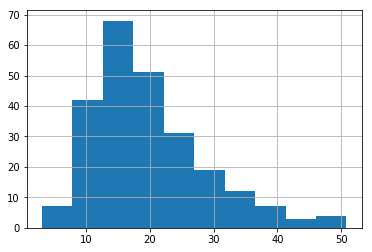

In [73]:
tips = sns.load_dataset('tips')
tips.total_bill.hist()

2) 성별로는 아래 그림과 같이 분포특성이 다르지 않으므로, 성별로 평균(중간) 값을 대체하는 것은 그리 논리적이지 않다.

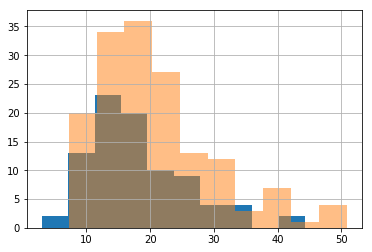

In [83]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
tips[tips.sex=='Female'].total_bill.hist(ax=ax)
tips[tips.sex=='Male'].total_bill.hist(ax=ax, alpha=0.5)

3) size 별로는 확실히 total_bill의 값이 다르므로, size별로 중간값을 구해 대체하는 전략은 바람직하다.

In [165]:
sizemean = tips.groupby('size').total_bill.mean()
sizemean

size
1     7.242500
2    16.448013
3    23.277632
4    28.613514
5    30.068000
6    34.830000
Name: total_bill, dtype: float64

In [166]:
sizemed = tips.groupby('size').total_bill.median()
sizemed

size
1     7.915
2    15.370
3    20.365
4    25.890
5    29.850
6    32.050
Name: total_bill, dtype: float64

In [106]:
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [194]:
tips = sns.load_dataset('tips')
np.random.seed(42)
data = tips.copy()
na_index = np.random.permutation(tips.index)[:4]
data.loc[na_index, 'total_bill'] = np.NaN
data.shape

(244, 7)

In [147]:
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [148]:
data.sex = np.where(data.sex == 'Female', 1, 0)
data.smoker = np.where(data.smoker == 'No', 0, 1)
data.time = np.where(data.time == 'Dinner', 1, 0)
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,1,0,Sun,1,2
1,10.34,1.66,0,0,Sun,1,3
2,21.01,3.50,0,0,Sun,1,3
3,23.68,3.31,0,0,Sun,1,2
4,24.59,3.61,1,0,Sun,1,4


In [149]:
days = pd.get_dummies(data['day'], prefix='')
days

,_Thur,_Fri,_Sat,_Sun
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
239,0,0,1,0
240,0,0,1,0
241,0,0,1,0
242,0,0,1,0


In [150]:
sizes = pd.get_dummies(data['size'], prefix='size')
sizes

,size_1,size_2,size_3,size_4,size_5,size_6
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
239,0,0,1,0,0,0
240,0,1,0,0,0,0
241,0,1,0,0,0,0
242,0,1,0,0,0,0


In [151]:
data.drop(['size', 'day'], axis=1).head()

,total_bill,tip,sex,smoker,time
0,16.99,1.01,1,0,1
1,10.34,1.66,0,0,1
2,21.01,3.50,0,0,1
3,23.68,3.31,0,0,1
4,24.59,3.61,1,0,1


In [152]:
data = pd.concat([data.drop(['size', 'day'], axis=1), 
                  days,
                  sizes
                 ], axis=1)
data.head()

,total_bill,tip,sex,smoker,time,_Thur,_Fri,_Sat,_Sun,size_1,size_2,size_3,size_4,size_5,size_6
0,16.99,1.01,1,0,1,0,0,0,1,0,1,0,0,0,0
1,10.34,1.66,0,0,1,0,0,0,1,0,0,1,0,0,0
2,21.01,3.50,0,0,1,0,0,0,1,0,0,1,0,0,0
3,23.68,3.31,0,0,1,0,0,0,1,0,1,0,0,0,0
4,24.59,3.61,1,0,1,0,0,0,1,0,0,0,1,0,0


In [153]:
trainset = data.dropna()
testset = data.loc[na_index]
trainset.shape, testset.shape

((240, 15), (4, 15))

In [159]:
X = trainset.drop('total_bill', axis=1).values
y = trainset['total_bill'].values

In [200]:
testX = testset.drop('total_bill', axis=1).values
testy = tips.loc[na_index, 'total_bill'].values

In [196]:
model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X[train,:], y[train])
    score = model.score(X[test,:], y[test])
    scores.append(score)
print(scores)

[0.4842687118606931, 0.5325909721596849, 0.5116971384232234]


In [197]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [198]:
model.predict(testX)

array([18.15290848, 14.01078259, 21.5502071 , 34.40262967])

In [201]:
testy

array([19.82,  8.77, 24.55, 25.89])

In [202]:
sizemean[tips.loc[na_index, 'size']].values

array([16.44801282, 16.44801282, 28.61351351, 28.61351351])

In [203]:
sizemed[tips.loc[na_index, 'size']].values

array([15.37, 15.37, 25.89, 25.89])

In [204]:
tips.loc[na_index, 'size'].values

array([2, 2, 4, 4], dtype=int64)

In [205]:
from sklearn.linear_model import Lasso
model = Lasso()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X[train,:], y[train])
    score = model.score(X[test,:], y[test])
    scores.append(score)
print(scores)

[0.4235111109684184, 0.5720154958860281, 0.3548348635552685]


In [206]:
model.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [207]:
model.predict(testX)

array([20.28955352, 15.83806899, 16.3622994 , 28.28322409])

In [209]:
testy

array([19.82,  8.77, 24.55, 25.89])

## 11.4 데이터 필터링
### 11.4.1 데이터 필터링 사용하기 ─ filter 메서드(227쪽)

In [111]:
tips = sns.load_dataset('tips')

print(tips.shape)

(244, 7)


In [112]:
print(tips['size'].value_counts())

2    156
3     38
4     37
5      5
6      4
1      4
Name: size, dtype: int64


In [113]:
tips_filtered = tips.\
    groupby('size').\
    filter(lambda x: x['size'].count() >= 30)

In [114]:
print(tips_filtered.shape)

(231, 7)


In [115]:
print(tips_filtered['size'].value_counts())

2    156
3     38
4     37
Name: size, dtype: int64


<font color='red'>[Quiz] </font> 다음과 같은 데이터 진단을 실시하자.
1. 전체 데이터의 total_bill과 tip의 평균과 중간값을 구하고, 
2. tip/total_bill의 값이 이상치를 식별한 후,
3. 이상치를 제거할 때의 total_bill과 tip의 평균과 중간값를 비교해보자.

In [185]:
totMM = tips[['total_bill', 'tip']].agg(['mean', 'median'])
totMM

,total_bill,tip
mean,19.785943,2.998279
median,17.795000,2.900000


In [186]:
tipRate = tips.tip/tips.total_bill
tipRate.head()

0    0.059447
1    0.160542
2    0.166587
3    0.139780
4    0.146808
dtype: float64

In [187]:
Qs = tipRate.quantile([.25, .75])
Qs = Qs.values
Qs

array([0.12912736, 0.19147549])

In [188]:
tipRateIQR = Qs[1] - Qs[0]
tipRateIQR

0.06234812458689154

- 이상치 하한: Q1 - 1.5 * IQR, 
- 이상치 하한: Q3 + 1.5 * IQR

In [189]:
outlierBounds = [q - (-1)**i * 1.5 * tipRateIQR for i, q in enumerate(Qs)]
outlierBounds

[0.03560517486275866, 0.2849976732103248]

In [190]:
outlierCondition = (tipRate > outlierBounds[1]) | (tipRate < outlierBounds[0])
outlierCondition

0      False
1      False
2      False
3      False
4      False
       ...  
239    False
240    False
241    False
242    False
243    False
Length: 244, dtype: bool

In [191]:
tips[outlierCondition]

,total_bill,tip,sex,smoker,day,time,size
67,3.07,1.00,Female,Yes,Sat,Dinner,1
172,7.25,5.15,Male,Yes,Sun,Dinner,2
178,9.60,4.00,Female,Yes,Sun,Dinner,2
232,11.61,3.39,Male,No,Sat,Dinner,2


In [110]:
tipRate[outlierCondition]

67     0.325733
172    0.710345
178    0.416667
232    0.291990
dtype: float64

In [192]:
tips[~outlierCondition][['total_bill', 'tip']].agg(['mean', 'median'])

,total_bill,tip
mean,19.984333,2.991833
median,17.855000,2.855000


In [193]:
totMM

,total_bill,tip
mean,19.785943,2.998279
median,17.795000,2.900000


## 11.5 GroupBy 객체
### 11.5.1 GroupBy 객체 탐색(229쪽)

In [116]:
tips_10 = sns.load_dataset('tips').sample(10, random_state=42) 
print(tips_10)

     total_bill   tip     sex smoker   day    time  size
24        19.82  3.18    Male     No   Sat  Dinner     2
6          8.77  2.00    Male     No   Sun  Dinner     2
153       24.55  2.00    Male     No   Sun  Dinner     4
211       25.89  5.16    Male    Yes   Sat  Dinner     4
198       13.00  2.00  Female    Yes  Thur   Lunch     2
176       17.89  2.00    Male    Yes   Sun  Dinner     2
192       28.44  2.56    Male    Yes  Thur   Lunch     2
124       12.48  2.52  Female     No  Thur   Lunch     2
9         14.78  3.23    Male     No   Sun  Dinner     2
101       15.38  3.00  Female    Yes   Fri  Dinner     2


In [119]:
grouped = tips_10.groupby('sex')
print(grouped)

In [120]:
grouped.groups

{'Male': Int64Index([24, 6, 153, 211, 176, 192, 9], dtype='int64'),
 'Female': Int64Index([198, 124, 101], dtype='int64')}

### 11.5.2 GroupBy 객체의 계산
#### 1) 그룹 오브젝트의 평균 구하기(230쪽)

In [121]:
avgs = grouped.mean() 
print(avgs)

        total_bill       tip      size
sex                                   
Male         20.02  2.875714  2.571429
Female       13.62  2.506667  2.000000


In [122]:
print(tips_10.columns)

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size'], dtype='object')


#### 2) 그룹 오브젝트에서 데이터 추출하고 반복하기(231쪽)
그룹 오브젝트 활용 참고 자료
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html

In [55]:
female = grouped.get_group('Female') 
print(female)

     total_bill   tip     sex smoker   day    time  size
198       13.00  2.00  Female    Yes  Thur   Lunch     2
124       12.48  2.52  Female     No  Thur   Lunch     2
101       15.38  3.00  Female    Yes   Fri  Dinner     2


In [56]:
for sex_group in grouped:
    print(sex_group)

('Male',      total_bill   tip   sex smoker   day    time  size
24        19.82  3.18  Male     No   Sat  Dinner     2
6          8.77  2.00  Male     No   Sun  Dinner     2
153       24.55  2.00  Male     No   Sun  Dinner     4
211       25.89  5.16  Male    Yes   Sat  Dinner     4
176       17.89  2.00  Male    Yes   Sun  Dinner     2
192       28.44  2.56  Male    Yes  Thur   Lunch     2
9         14.78  3.23  Male     No   Sun  Dinner     2)
('Female',      total_bill   tip     sex smoker   day    time  size
198       13.00  2.00  Female    Yes  Thur   Lunch     2
124       12.48  2.52  Female     No  Thur   Lunch     2
101       15.38  3.00  Female    Yes   Fri  Dinner     2)


In [123]:
for sex, group in grouped:
    print('='*20)
    print(sex)
    print(group)

Male
     total_bill   tip   sex smoker   day    time  size
24        19.82  3.18  Male     No   Sat  Dinner     2
6          8.77  2.00  Male     No   Sun  Dinner     2
153       24.55  2.00  Male     No   Sun  Dinner     4
211       25.89  5.16  Male    Yes   Sat  Dinner     4
176       17.89  2.00  Male    Yes   Sun  Dinner     2
192       28.44  2.56  Male    Yes  Thur   Lunch     2
9         14.78  3.23  Male     No   Sun  Dinner     2
Female
     total_bill   tip     sex smoker   day    time  size
198       13.00  2.00  Female    Yes  Thur   Lunch     2
124       12.48  2.52  Female     No  Thur   Lunch     2
101       15.38  3.00  Female    Yes   Fri  Dinner     2


In [57]:
for sex_group in grouped:
    print('the type is: {}\n'.format(type(sex_group)))
    print('the length is: {}\n'.format(len(sex_group)))

    first_element = sex_group[0] 
    print('the first element is: {}\n'.format(first_element))
    print('it has a type of: {}\n'.format(type(sex_group[0])))

    second_element = sex_group[1] 
    print('the second element is:\n{}\n'.format(second_element))
    print('it has a type of: {}\n'.format(type(second_element)))

    print('what we have:') 
    print(sex_group)

    break

the type is: <class 'tuple'>

the length is: 2

the first element is: Male

it has a type of: <class 'str'>

the second element is:
     total_bill   tip   sex smoker   day    time  size
24        19.82  3.18  Male     No   Sat  Dinner     2
6          8.77  2.00  Male     No   Sun  Dinner     2
153       24.55  2.00  Male     No   Sun  Dinner     4
211       25.89  5.16  Male    Yes   Sat  Dinner     4
176       17.89  2.00  Male    Yes   Sun  Dinner     2
192       28.44  2.56  Male    Yes  Thur   Lunch     2
9         14.78  3.23  Male     No   Sun  Dinner     2

it has a type of: <class 'pandas.core.frame.DataFrame'>

what we have:
('Male',      total_bill   tip   sex smoker   day    time  size
24        19.82  3.18  Male     No   Sat  Dinner     2
6          8.77  2.00  Male     No   Sun  Dinner     2
153       24.55  2.00  Male     No   Sun  Dinner     4
211       25.89  5.16  Male    Yes   Sat  Dinner     4
176       17.89  2.00  Male    Yes   Sun  Dinner     2
192       28.44  

### 11.5.3 여러 group key 사용하기
#### 1) 그룹 오브젝트 계산하고 살펴보기(234쪽)

In [124]:
bill_sex_time = tips_10.groupby(['sex', 'time'])
group_avg = bill_sex_time.mean() 

group_avg

total_bill       tip      size
sex    time                                  
Male   Lunch    28.440000  2.560000  2.000000
       Dinner   18.616667  2.928333  2.666667
Female Lunch    12.740000  2.260000  2.000000
       Dinner   15.380000  3.000000  2.000000

In [59]:
print(type(group_avg))

<class 'pandas.core.frame.DataFrame'>


In [60]:
print(group_avg.columns)

Index(['total_bill', 'tip', 'size'], dtype='object')


#### 2) group index에 대한 이해

In [62]:
group_avg.index

MultiIndex([(  'Male',  'Lunch'),
            (  'Male', 'Dinner'),
            ('Female',  'Lunch'),
            ('Female', 'Dinner')],
           names=['sex', 'time'])

In [63]:
group_method = tips_10.groupby(['sex', 'time']).mean().reset_index() 
print(group_method)

      sex    time  total_bill       tip      size
0    Male   Lunch   28.440000  2.560000  2.000000
1    Male  Dinner   18.616667  2.928333  2.666667
2  Female   Lunch   12.740000  2.260000  2.000000
3  Female  Dinner   15.380000  3.000000  2.000000


In [64]:
group_param = tips_10.groupby(['sex', 'time'], as_index=False).mean( ) 
print(group_param)

      sex    time  total_bill       tip      size
0    Male   Lunch   28.440000  2.560000  2.000000
1    Male  Dinner   18.616667  2.928333  2.666667
2  Female   Lunch   12.740000  2.260000  2.000000
3  Female  Dinner   15.380000  3.000000  2.000000


### [Advanced] groupby axis=1 

In [127]:
people = pd.DataFrame(np.random.randn(5,5),
                   columns=['a', 'b', 'c', 'd', 'e'],
                   index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people

,a,b,c,d,e
Joe,-0.734548,-0.959895,1.104928,0.634240,3.061095
Steve,-1.318570,0.720387,0.315891,0.059281,0.910512
Wes,-0.029725,-1.936376,-0.847358,1.364433,1.172029
Jim,-0.373119,0.503597,2.783938,-0.031187,-0.011583
Travis,0.190599,0.606976,-0.348901,0.606129,-1.944230


In [128]:
people[2:3][['b', 'c']] = np.nan #NA 값 몇 개를 추가. np.nan 대신 None도 가능.

C:\ai\python\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [132]:
people.iloc[2:3, 1:3]

,b,c
Wes,NaN,NaN


<font color='red'>[Quiz] </font> 결과는 어떻게 될까?

In [129]:
people

,a,b,c,d,e
Joe,-0.734548,-0.959895,1.104928,0.634240,3.061095
Steve,-1.318570,0.720387,0.315891,0.059281,0.910512
Wes,-0.029725,NaN,NaN,1.364433,1.172029
Jim,-0.373119,0.503597,2.783938,-0.031187,-0.011583
Travis,0.190599,0.606976,-0.348901,0.606129,-1.944230


In [133]:
mapping = {'a':'red', 'b':'red', 'c':'blue',
           'd':'blue', 'e':'red', 'f':'orange'}

In [134]:
by_column = people.groupby(mapping, axis=1)

In [137]:
by_column.groups

{'blue': Index(['c', 'd'], dtype='object'),
 'red': Index(['a', 'b', 'e'], dtype='object')}

In [138]:
people.T.groupby(mapping, axis=0).mean().T

,blue,red
Joe,0.869584,0.455551
Steve,0.187586,0.104110
Wes,1.364433,0.571152
Jim,1.376376,0.039632
Travis,0.128614,-0.382218


<font color='red'>[Quiz] </font> 결과는 어떻게 될까?

In [135]:
by_column.sum()

,blue,red
Joe,1.739169,1.366653
Steve,0.375172,0.312329
Wes,1.364433,1.142304
Jim,2.752751,0.118895
Travis,0.257228,-1.146655


<font color='red'>[Quiz] </font> 결과는 어떻게 될까?

In [140]:
people

,a,b,c,d,e
Joe,-0.734548,-0.959895,1.104928,0.634240,3.061095
Steve,-1.318570,0.720387,0.315891,0.059281,0.910512
Wes,-0.029725,NaN,NaN,1.364433,1.172029
Jim,-0.373119,0.503597,2.783938,-0.031187,-0.011583
Travis,0.190599,0.606976,-0.348901,0.606129,-1.944230


In [141]:
maplist = ['r', 'r', 'b', 'b', 'r']
by_column = people.groupby(maplist, axis=1)
by_column.sum()

,b,r
Joe,1.739169,1.366653
Steve,0.375172,0.312329
Wes,1.364433,1.142304
Jim,2.752751,0.118895
Travis,0.257228,-1.146655
